# Transfer learning with tensorflow part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

## Creating helper functions

In previous notebooks, we created some helper functions that make our code cleaner and easier to understand.

It's a good iyou can download and import into your notebooks (or elsewhere). We've done this for some of the functions we've used previously here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [35]:
# Import helper function s we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [36]:
import os
import tensorflow as tf

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"

tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(4)

tf.config.set_visible_devices([], 'GPU')

print("CPUs:", os.cpu_count())


CPUs: 24


# let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` to fine-tune on our own data. We'll start by downloading a dataset and then using a pretrained model to fine-tune on it.



In [37]:
# import zipfile
# import urllib.request

# # Baixar o arquivo ZIP
# url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
# zip_path = "10_food_classes_10_percent.zip"
# urllib.request.urlretrieve(url, zip_path)

# # # Descompactar o arquivo ZIP
# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall()

In [38]:
# check out how many images and subdirectorys are in our dataset
from helper_functions import walk_through_dir

walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [39]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [40]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64   # melhor que 32 para CPU forte


In [41]:

# Parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # pode subir para 64 depois

# ---- Dataset original (mantém class_names) ----
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

# ---- Acesso às classes (sem erro, como antes) ----
class_names = train_ds_raw.class_names
num_classes = len(class_names)

print(class_names)

# ---- Pipeline otimizado (para treino) ----
AUTOTUNE = tf.data.AUTOTUNE

train_data_10_percent = train_ds_raw.cache().prefetch(AUTOTUNE)
test_data = test_ds_raw.cache().prefetch(AUTOTUNE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [42]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [43]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[ 12.642858     4.642857     1.6428572 ]
   [ 12.97449      4.9744897    1.9744899 ]
   [ 14.857143     6.857143     3.857143  ]
   ...
   [254.40312    247.8422     241.41367   ]
   [251.81125    254.66837    245.52548   ]
   [245.68332    247.96896    230.61179   ]]

  [[ 14.           7.           1.        ]
   [ 14.           7.           1.        ]
   [ 14.285714     7.285714     1.2857141 ]
   ...
   [255.         253.6379     247.79614   ]
   [251.14798    255.         248.58669   ]
   [242.16798    242.45363    226.93309   ]]

  [[ 17.428572     8.428572     3.4285717 ]
   [ 15.5          6.5          1.5       ]
   [ 15.214286     6.214286     1.2142859 ]
   ...
   [251.59688    254.23477    248.50017   ]
   [249.94391    255.         249.51526   ]
   [246.66301    244.07622    231.2343    ]]

  ...

  [[167.4439      48.872425     7.219402  ]
   [169.28067     53.209236     6.4235206 ]
   [174.96925     59.39783      7.7549734 ]
   ...
   [250.16835    141.168

https://www.tensorflow.org/guide/keras/functional_api 

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

## Model 0: Building a transfer learning model using the Keras Functional API

The **sequential API** is straight-foward, it runs our layers in sequential order.

But the **functional API*** gives us more flexibility with our models

In [44]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after base model: {x.shape}")

# 6. Average Pool the outputs of the base model (aggregate the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
print(f"Shape after output layer: {outputs.shape}")

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save the history
# Resize test_data to match the input size of the model
test_data_resized = test_data.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_resized,
                                validation_steps=int(0.25 * len(test_data_resized)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])


Shape after base model: (None, 7, 7, 1280)
Shape after Global Average Pooling2D: (None, 1280)
Shape after output layer: (None, 10)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20260125-181909
Epoch 1/5
24/24 [==============================] - 12s 370ms/step - loss: 1.8791 - accuracy: 0.4307 - val_loss: 1.2882 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 8s 327ms/step - loss: 1.0867 - accuracy: 0.7827 - val_loss: 0.8466 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 8s 330ms/step - loss: 0.7774 - accuracy: 0.8267 - val_loss: 0.6842 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 8s 326ms/step - loss: 0.6288 - accuracy: 0.8640 - val_loss: 0.5945 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 8s 328ms/step - loss: 0.5468 - accuracy: 0.8853 - val_loss: 0.5331 - val_accuracy: 0.8783


In [45]:
# Evaluate on the full test test_data
model_0.evaluate(test_data)

79/79 [==============================] - 14s 175ms/step - loss: 0.5475 - accuracy: 0.8688


[0.5474962592124939, 0.8687999844551086]

In [46]:
# Check the layers in our model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [47]:
# How about we get a summary of our base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['normalization_2

In [48]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

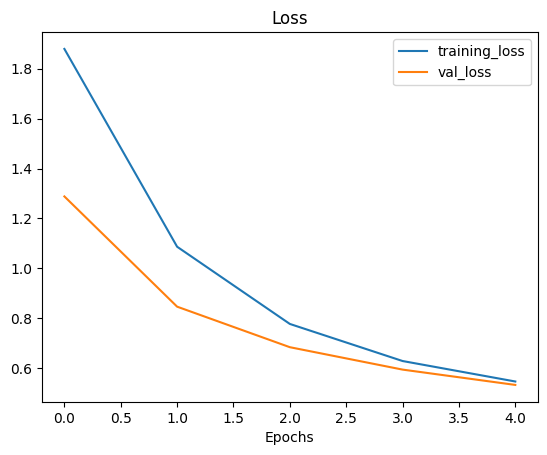

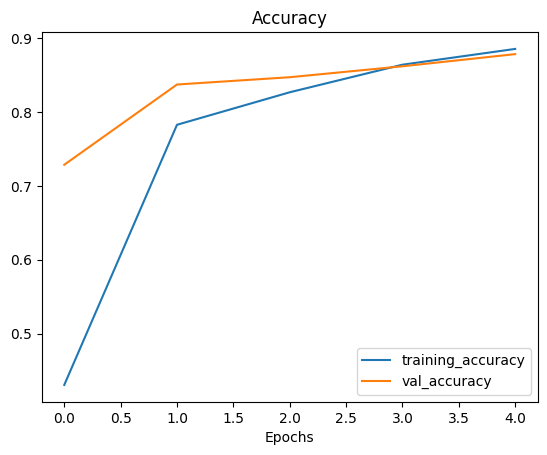

In [49]:
# Check out our model's training curves 
plot_loss_curves(history_10_percent) # from helper_functions.py

## Getting a feature vector from a trained model

Let's demonstrate the Global Average pooling 2D layer...

We have a tensor after our model goes through `base_model` os shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [50]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"Shape of input tensor: {input_tensor.shape}\n")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")


Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

Shape of input tensor: (1, 4, 4, 3)

Shape of Global Average Pooled 2D tensor: (1, 3)


In [51]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

>Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a feature vector (a long tensor of numbers wich represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) wich can then be used to extract patterns out of fo our own specific problem.

# Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:


1. `model_1`: use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the tranining with data augmentation
3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4: use fine-tuning transfer learning on 100% of the training data with data augmentation
   
> Note: Throughtout all experiments the same test data will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [52]:
# Download and unzip the data
# # Get the data


import zipfile
import urllib.request

#Baixar o arquivo ZIP
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
zip_path = "10_food_classes_1_percent.zip"
urllib.request.urlretrieve(url, zip_path)

# # Descompactar o arquivo ZIP
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall()

In [53]:
# Create training and test datasets
train_dir = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"



In [54]:
#How many images in each folder?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [55]:
# Parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 64  # pode subir para 64 depois

# ---- Dataset original (mantém class_names) ----
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

# ---- Acesso às classes (sem erro, como antes) ----
class_names = train_ds_raw.class_names
num_classes = len(class_names)

print(class_names)

# ---- Pipeline otimizado (para treino) ----
AUTOTUNE = tf.data.AUTOTUNE

train_data_1_percent = train_ds_raw.cache().prefetch(AUTOTUNE)
test_data = test_ds_raw.cache().prefetch(AUTOTUNE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow data Aumentation Documentation: [data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)

Off the top our heads, after reading the docs, the benefits of using data augmentaion inside the model are:

* Preprocessing of images (aumenting then) happens on the GPU (much faster) rather than the GPU.
* Image data augmentaion only happens durin the training, so we can still export our model and use elsewhere.

In [56]:
from os import name
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomWidth(0.2),
        preprocessing.RandomHeight(0.2),
       # preprocessing.Rescale(1./255)  # Keeep for models like Rsnet50V02 but EfficientNet doesn't need
    ], name="data_augmentation"
)

### Visualize our data augmentation layer (and see what happens to our data)

Text(0.5, 1.0, 'Augmented random image from class: chicken_curry')

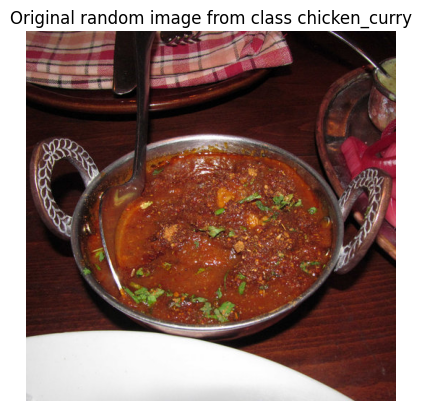

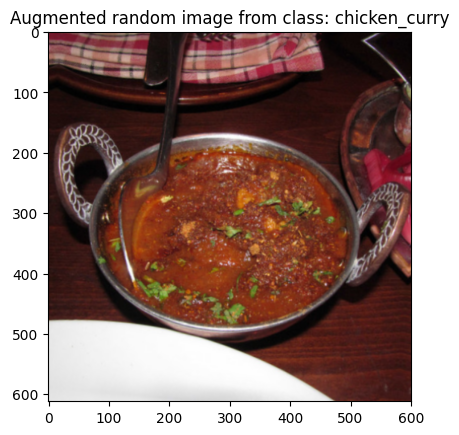

In [57]:
# View a random image and compare it with its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Escolhe uma classe aleatória
target_class = random.choice(class_names)

# Diretório correto da classe
target_dir = os.path.join(train_dir, target_class)

# Escolhe uma imagem aleatória dessa classe
random_image = random.choice(os.listdir(target_dir))
random_image_path = os.path.join(target_dir, random_image)

# Lê a imagem
img = mpimg.imread(random_image_path)

# Mostra a imagem
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis("off")


# Now let's plot our augmented rando image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
#print(augmented_img)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [58]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs with the correct shape
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Pass the data through the base model (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the outputs of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_data_augmentation")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_augmentation/20260125-182015
Epoch 1/5
2/2 [==============================] - 7s 4s/step - loss: 2.3694 - accuracy: 0.0857 - val_loss: 2.2438 - val_accuracy: 0.1594
Epoch 2/5
2/2 [==============================] - 4s 3s/step - loss: 2.1600 - accuracy: 0.1429 - val_loss: 2.1793 - val_accuracy: 0.1672
Epoch 3/5
2/2 [==============================] - 4s 3s/step - loss: 1.9793 - accuracy: 0.2857 - val_loss: 2.1067 - val_accuracy: 0.2406
Epoch 4/5
2/2 [==============================] - 4s 3s/step - loss: 1.8756 - accuracy: 0.4000 - val_loss: 2.0489 - val_accuracy: 0.2609
Epoch 5/5
2/2 [==============================] - 4s 3s/step - loss: 1.7669 - accuracy: 0.4143 - val_loss: 1.9817 - val_accuracy: 0.3109


In [59]:
# Check our model summary
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [60]:
# Evaluate on the full test test_data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

40/40 [==============================] - 12s 297ms/step - loss: 2.0001 - accuracy: 0.2956


[2.000101089477539, 0.2955999970436096]

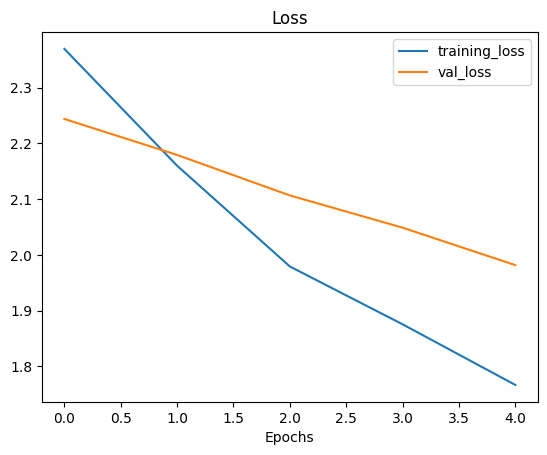

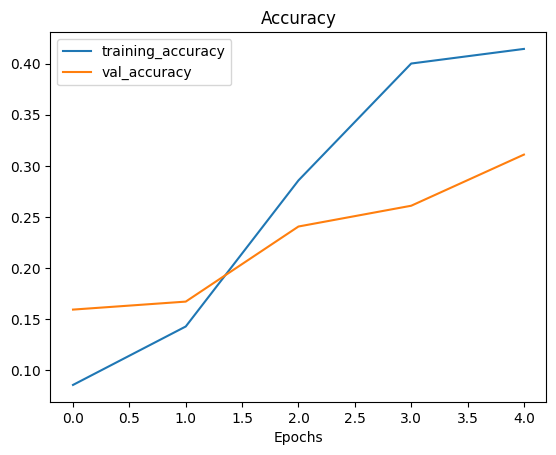

In [61]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning on 10% of the data and data augmentation

In [62]:
# Get 10% of the data
train_dir_10_percent = "C:\Project_1\10_food_classes_10_percent\train"
test_dir_10_percent = "C:\Project_1\10_food_classes_10_percent\test"

In [63]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [64]:
# Parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Diretórios de 10%
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

# Dataset original (mantém class_names)
train_ds_raw_10 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_ds_raw_10 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10_percent,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

# Classes
class_names = train_ds_raw_10.class_names
num_classes = len(class_names)
print(class_names)

# Pipeline otimizado
AUTOTUNE = tf.data.AUTOTUNE

train_data_10_percent = train_ds_raw_10.cache().prefetch(AUTOTUNE)
test_data_10_percent = test_ds_raw_10.cache().prefetch(AUTOTUNE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [65]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, None, None, 3)     0         
                                                                 
 random_rotation_1 (RandomR  (None, None, None, 3)     0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, None, None, 3)     0         
                                                                 
 random_width_1 (RandomWidt  (None, None, None, 3)     0         
 h)                                                              
                                                                 
 random_height_1 (RandomHei  (None, None, None, 3)     0         
 ght)                                                            
                                                 

In [72]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
], name = "data_augmentation")

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)

# Create a base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (inclcluding the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # Don't train the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # Pool the outputs of the base model
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)   # Put a dense layer on as the output

# Create the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",  
                optimizer=tf.keras.optimizers.Adam(),  
                metrics=["accuracy"])  

model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281